In [1]:
from dataset import *
import torch
print(torch.__version__)
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from PIL import Image
from modules import *
from save_history import *

1.5.0


Load Claudio data

In [2]:
from os.path import join
from czifile import CziFile
with CziFile(join("../../test2.czi")) as czi:
    
    image_arrays = czi.asarray()
    meta = czi.metadata(raw=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\l_pip\\OneDrive\\Escritorio\\Tesiss\\Deteccion-automatica-de-oscilaciones-celulares\\test2.czi'

Create PNG images

In [3]:
import ipywidgets as widgets
import cv2
from tqdm.notebook import tqdm

In [4]:
def normalize_image(img):
    img = (img/img.max())*255
    return img.astype('uint8')

def denoise_image(img, h=30):
    # Filtro mediana para eliminar ruido impulsivo
    img = cv2.medianBlur(img, 5)
    # Non-local mean denoising http://www.ipol.im/pub/art/2011/bcm_nlm/
    img = cv2.fastNlMeansDenoising(img, None, h=h, templateWindowSize=7, searchWindowSize=21)
    return img
def get_binary_mask(img):
    # Adaptive thresholding    
    binary_mask = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, 21, 0)
    # Cerradura morfologica
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, 
                                   kernel=np.ones((3,3),np.uint8), iterations = 4)
    return binary_mask
def get_markers(dist, threshold=0.3):
    ret, sure_fg = cv2.threshold(dist, threshold*dist.max(), 255, 0)
    ret, markers = cv2.connectedComponents(sure_fg.astype('uint8'))
    return markers
def watershed_pipeline(img, th=0.1):
    #img = denoise_image(img)
    #binary_mask = ~get_binary_mask(img)
    dist_transform = cv2.distanceTransform(img, cv2.DIST_L2, 5)
    markers = get_markers(dist_transform, threshold=th)
    watershed =  cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers.copy())
    return markers, watershed

z = 0

In [5]:
import matplotlib.pyplot as plt

for x in range (0, 60):
    img = image_arrays[0, 0, 0, x, 0, :, :, 0]
    img = normalize_image(img)
    img = cv2.equalizeHist(img)
    img = denoise_image(img, 30)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, 
                                   kernel=np.ones((3,3),np.uint8), iterations = 4)
    plt.imsave(join("Claudio_png", "test", str(x)+".png"), img, cmap='gray_r') #guarda en escala de grises invertido

Load model

In [5]:
model = torch.load('../model_epoch_100.pwf', map_location=torch.device('cpu')).module.cpu()
model.eval()

C:\Users\l_pip\Anaconda3\envs\Tesis\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\l_pip\Anaconda3\envs\Tesis\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\l_pip\Anaconda3\envs\Tesis\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original sourc

CleanU_Net(
  (Conv_down1): Conv_down(
    (conv): Double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv_down2): Conv_down(
    (conv): Double_conv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv_down3): Conv_down(
    (conv): Double_conv(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))


## Torch dataset para las imágenes de Claudio

Luis:

Quiero que entiendas perfectamente lo que está pasando en el siguiente bloque, lee la documentación de torchvision
- El dataset lo creo con ImageFolder. Las imágenes deben estar en "Claudio_png/test"
- Le aplico transforms para llevarlo a escala de grises e imitar el crop/padding que se usaba nates
- Finalmente le aplico una transformación custom para "corregir la imagen"

> El objetivo es que las imágenes de Claudio se vean más parecidas a las del challenge

Por ejemplo subir el contraste mejora bastante la detección pero aun no es perfecto. Revisa tu que otras transformaciones funcionales podrían servir https://pytorch.org/docs/stable/torchvision/transforms.html

También podría servir usar las funciones que dejé en el notebook classic en particular denoise_image

<IPython.core.display.Javascript object>


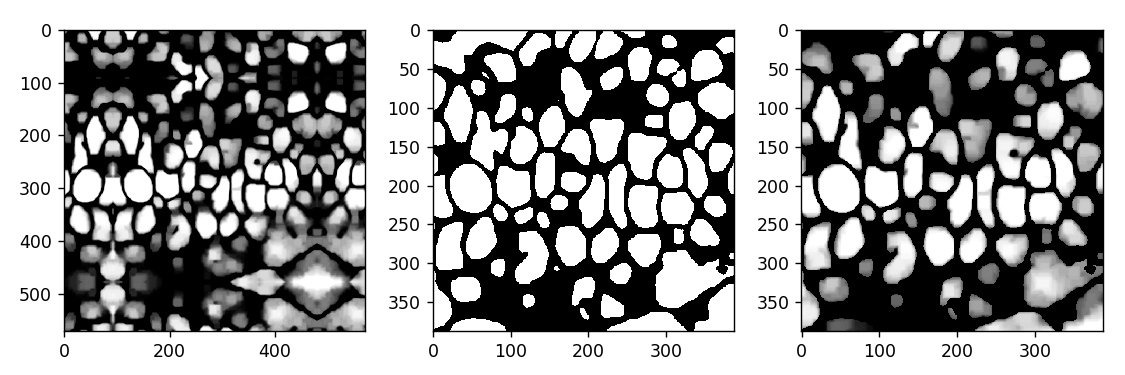

In [6]:
import torchvision
import torchvision.transforms.functional as TF

# https://pytorch.org/docs/stable/torchvision/transforms.html
#equ = cv2.equalizeHist(img)
class ImproveImageTransform:
    
    def __init__(self, contrast_factor=1, brightness_factor=1, saturation_factor=1):
        self.saturation_factor= saturation_factor # 0 will give a black and white image,1 will give the original image while 2 will enhance the saturation by a factor of 2.
        self.contrast_factor = contrast_factor
        self.brightness_factor = brightness_factor

    def __call__(self, x):
        #x = TF.adjust_gamma(x, gamma=1)
        x = TF.adjust_saturation(x, self.saturation_factor)
        x = TF.adjust_brightness(x, self.brightness_factor)
        x = TF.adjust_contrast(x, self.contrast_factor)
        return x

my_transforms = torchvision.transforms.Compose([torchvision.transforms.Grayscale(),
                                                torchvision.transforms.CenterCrop(388),
                                                #torchvision.transforms.FiveCrop(388),
                                                torchvision.transforms.Pad(padding=(572-388)//2,
                                                                           padding_mode='reflect'),
                                                ImproveImageTransform(contrast_factor=3 , saturation_factor=0),
                                                torchvision.transforms.ToTensor()])
             
            
claudio_dataset = torchvision.datasets.ImageFolder("Claudio_png", transform=my_transforms)

claudio_loader = torch.utils.data.DataLoader(dataset=claudio_dataset, batch_size=1, 
                                             num_workers=0, shuffle=False)

img_list = []
water_list = []
for image, label in tqdm(claudio_loader):
    with torch.no_grad():
        output = model.forward(image)
        output = torch.argmax(output, dim=1).float()
        img1 = output[0].detach().numpy().astype('uint8')*255
        marker, water = watershed_pipeline(img1)
        img_list.append(img1)
        water_list.append(water)
    

%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
pad = (572-388)//2
ax[0].imshow(image.numpy()[0, 0], cmap=plt.cm.Greys_r)
ax[1].imshow(output.numpy()[0], cmap=plt.cm.Greys_r)

borders_on_top = image.numpy()[0, 0, pad:-pad, pad:-pad].copy()
idx = np.where(output.numpy()[0].astype(int) == 0)
borders_on_top[idx[0], idx[1]] = 0
ax[2].imshow(borders_on_top, cmap=plt.cm.Greys_r)

<IPython.core.display.Javascript object>


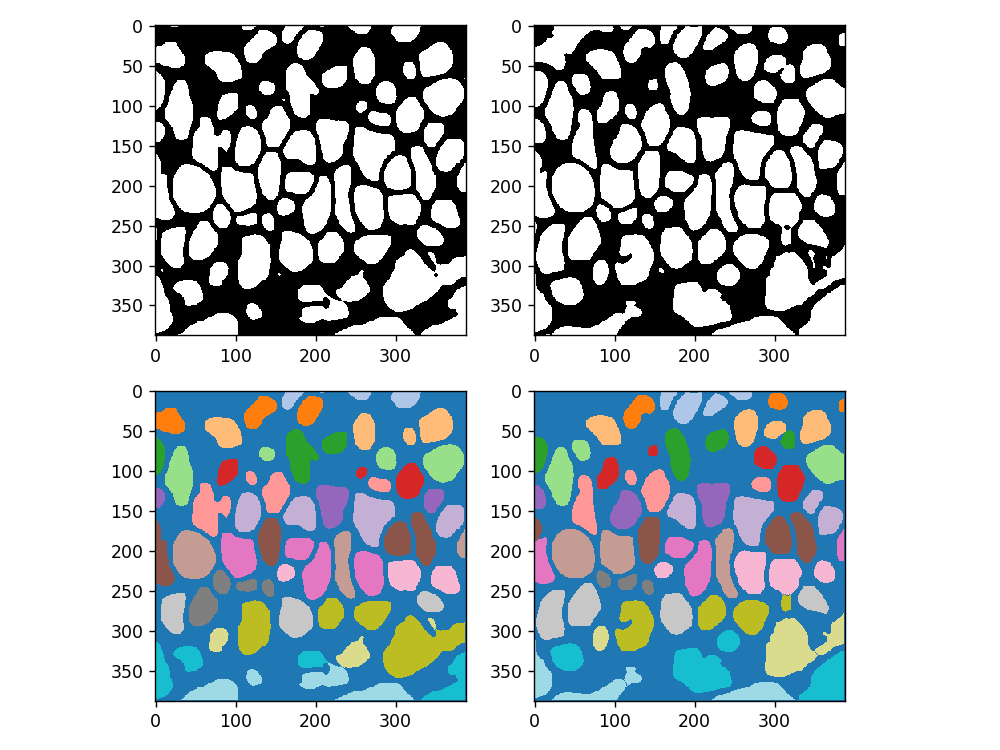

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
ax[0, 0].imshow(img_list[0], cmap=plt.cm.Greys_r)
ax[1, 0].imshow(water_list[0], cmap=plt.cm.tab20)
ax[0, 1].imshow(img_list[58], cmap=plt.cm.Greys_r)
ax[1, 1].imshow(water_list[58], cmap=plt.cm.tab20)

<IPython.core.display.Javascript object>


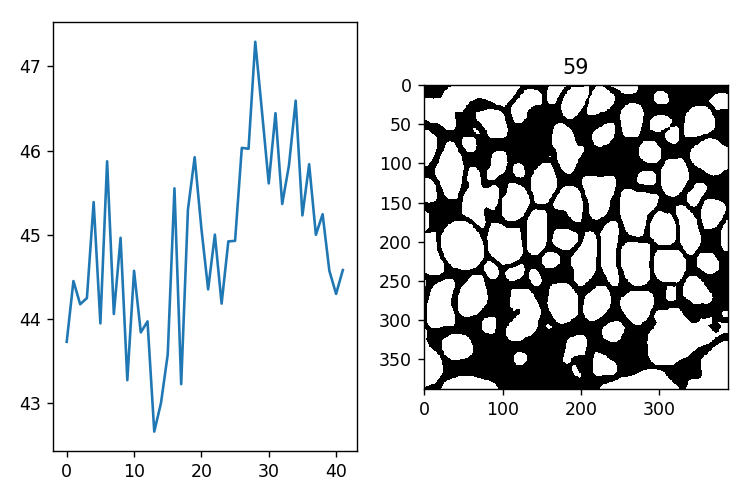

In [37]:
total_area = np.prod(water.shape)

cell_idx = 2
cell_coords = np.mean(np.where(water_list[0]==cell_idx), axis=1)
size_cell = []
cell_idx_history = [cell_idx]

for water in water_list[1:]:
    # Get coords of all cells
    new_cords = [np.mean(np.where(water==idx), axis=1) for idx in np.unique(water)[1:]]
    # Find nearest neightbor index
    closest_idx = np.argmin(np.sum((np.stack(new_cords) - cell_coords)**2, axis=1))
    
    #if distancias iguales, if celula desaparece, if distancia mayor a cierta cantidad de pixeles, 
    #medir distancia, if dos celulas se fusionan , if si dos tienen 2 celulas con misma next la que tenga menor
    nn_idx = np.unique(water)[1:][closest_idx]
    # Save index and area, agregar condiciones 
    cell_idx_history.append(nn_idx)
    size_cell.append(100*len(np.where(water == nn_idx)[0])/total_area)
    # update cell coords
    cell_coords = np.mean(np.where(water==nn_idx), axis=1)
    
#Adaptar visualizacion
# AGREGAR RESTRICCIONES #
#elimino los menores a 1
new_size_cell=[]
for size in size_cell:
    if (size>1):
        new_size_cell.append(size)
        
fig, ax = plt.subplots(1,2, figsize=(6, 4), tight_layout=True)
ax[0].plot(new_size_cell)

from matplotlib.animation import FuncAnimation

def update(k):
    ax[1].cla()
    img = img_list[k].copy()
    img[water_list[k]==cell_idx_history[k]] = 255
    ax[1].imshow(img, cmap=plt.cm.Greys_r)
    ax[1].set_title(k)
    
ani = FuncAnimation(fig, update, frames=range(60), repeat=False, interval=200)

In [33]:
new_size_cell

[43.72741524072696,
 44.449463279838454,
 44.17379636518227,
 44.2468647040068,
 45.38739504729514,
 45.87230311403975,
 44.963598682112874,
 43.27173450951217,
 44.571022425337446,
 43.83901052184079,
 43.96986927409927,
 43.00071739823573,
 43.57596450207248,
 45.55080242321182,
 45.29772026782867,
 45.92079392071421,
 45.072536932723985,
 44.3504888936125,
 45.00079710915081,
 44.18110319906472,
 44.92042193644383,
 44.9270645127006,
 46.03172494420236,
 46.02109682219152,
 47.29248591773833,
 46.4595068551387,
 45.60925709427144,
 46.444228929748114,
 45.822483792113935,
 46.592358380274206,
 45.83709745987884,
 44.99880433627378,
 45.243251142523114,
 44.57168668296312,
 44.29668402593262,
 44.57965777447125]

In [19]:
size_cell

[43.72741524072696,
 44.449463279838454,
 44.17379636518227,
 44.2468647040068,
 45.38739504729514,
 43.94595599957488,
 45.87230311403975,
 44.05821553831438,
 44.963598682112874,
 0.31950791795089806,
 0.3826123923902646,
 0.589860771601658,
 0.3925762567754278,
 0.41383250079710915,
 0.3872621957700074,
 43.27173450951217,
 44.571022425337446,
 43.83901052184079,
 43.96986927409927,
 42.66061749388883,
 43.00071739823573,
 43.57596450207248,
 45.55080242321182,
 43.223907960463386,
 0.2823094909129557,
 0.2158837283452014,
 0.20392709108300563,
 45.29772026782867,
 45.92079392071421,
 45.072536932723985,
 44.3504888936125,
 45.00079710915081,
 44.18110319906472,
 0.6097885003719843,
 44.92042193644383,
 44.9270645127006,
 46.03172494420236,
 46.02109682219152,
 47.29248591773833,
 46.4595068551387,
 0.6463226697842491,
 0.2530821553831438,
 45.60925709427144,
 46.444228929748114,
 0.6277234562652779,
 45.364810288022106,
 45.822483792113935,
 46.592358380274206,
 45.22930173238389,


<IPython.core.display.Javascript object>


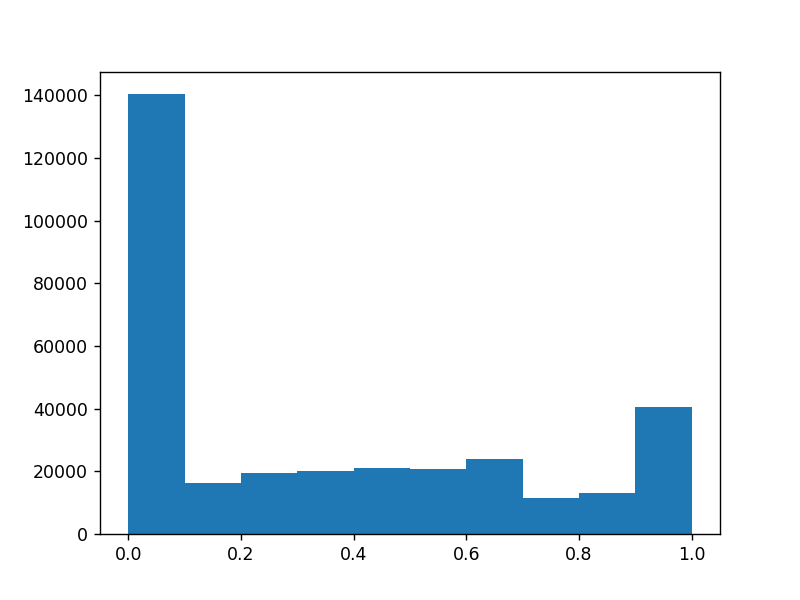

(array([140423.,  16390.,  19357.,  20235.,  21014.,  20895.,  24043.,
         11405.,  12954.,  40468.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

In [14]:
plt.figure()
plt.hist(image.numpy()[0, 0].ravel())

Alternative, adapt orignal code:

In [10]:
class ClaudioDataTest(Dataset):

    def __init__(self, image_path, in_size=572, out_size=388):
        '''
        Args:
            image_path = path where test images are located
            mask_path = path where test masks are located
        '''
        # paths to all images and masks

        self.image_arr = glob.glob(str(image_path) + str("/*"))
        self.in_size = in_size
        self.out_size = out_size
        self.data_len = len(self.image_arr)

    def __getitem__(self, index):
        '''Get specific data corresponding to the index
        Args:
            index: an integer variable that calls(indext)th image in the
                path
        Returns:
            Tensor: 4 cropped data on index which is converted to Tensor
        '''

        single_image = self.image_arr[index]
        img_as_img = Image.open(single_image)
        # img_as_img.show()
        # Convert the image into numpy array
        # OJO: ACA LA IMAGEN SE CORTA Y SE BOTAN LOS CANALES
        img_as_np = np.asarray(img_as_img)[:self.in_size, :self.in_size, 0]
        pad_size = int((self.in_size - self.out_size)/2)
        img_as_np = np.pad(img_as_np, pad_size, mode="symmetric")
        img_as_np = multi_cropping(img_as_np,
                                   crop_size=self.in_size,
                                   crop_num1=2, crop_num2=2)

        # Empty list that will be filled in with arrays converted to tensor
        processed_list = []

        for array in img_as_np:

            # SANITY CHECK: SEE THE PADDED AND CROPPED IMAGES
            # array_image = Image.fromarray(array)

            # Normalize the cropped arrays
            img_to_add = normalization2(array, max=1, min=0)
            # Convert normalized array into tensor
            processed_list.append(img_to_add)

        img_as_tensor = torch.Tensor(processed_list)
        #  return tensor of 4 cropped images
        #  top left, top right, bottom left, bottom right respectively.
        return img_as_tensor

    def __len__(self):

        return self.data_len
    
claudio_dataset = ClaudioDataTest("Claudio_png/test")
claudio_loader = torch.utils.data.DataLoader(dataset=claudio_dataset, batch_size=1, 
                                             num_workers=0, shuffle=False)

for images_t in claudio_loader:
    stacked_img = torch.Tensor([])
    
    for index in range(images_t.size()[1]):
        print(index)
        with torch.no_grad():
            image_t = Variable(images_t[:, index, :, :].unsqueeze(0))            
            # print(image_v.shape, mask_v.shape)
            output_t = model.forward(image_t)
            output_t = torch.argmax(output_t, dim=1).float()
            stacked_img = torch.cat((stacked_img, output_t))
        break
    break


0


<IPython.core.display.Javascript object>


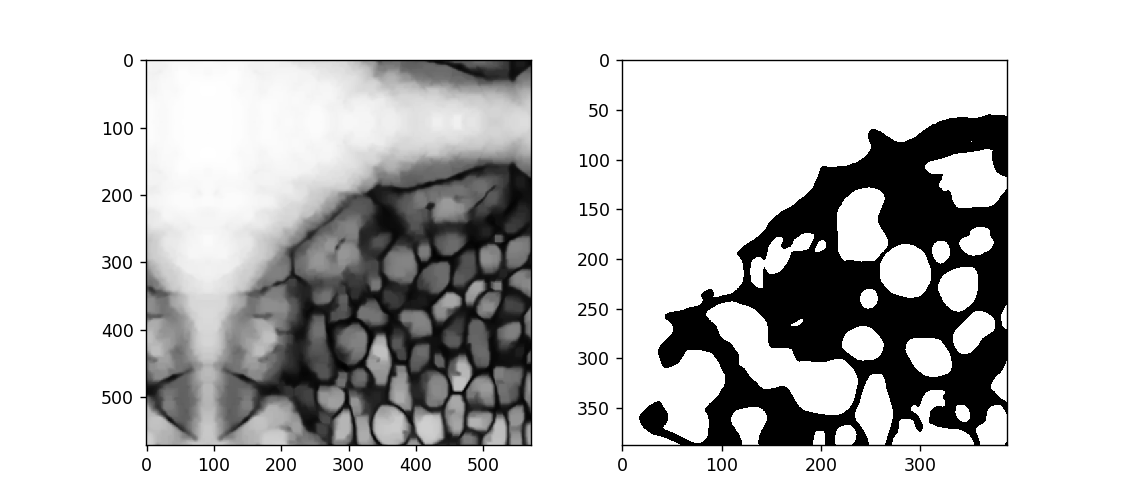

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].imshow(image_t.numpy()[0, 0], cmap=plt.cm.Greys_r)
ax[1].imshow(output_t.numpy()[0], cmap=plt.cm.Greys_r)